<a href="https://colab.research.google.com/github/svelezg/holbertonschool-machine_learning/blob/master/0x03_hyperparameter_tuning_BayesOpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install GPy==1.9.8
!pip install GPyOpt==1.2.1

     |████████████████████████████████| 993kB 4.4MB/s 
     |████████████████████████████████| 71kB 8.4MB/s 
  Created wheel for GPy: filename=GPy-1.9.8-cp36-cp36m-linux_x86_64.whl size=2626086 sha256=1c7272dfee6c63f81eb09cb18e91c59957ec75d7e700bd9f8e23ca485614c541
  Stored in directory: /root/.cache/pip/wheels/96/ee/cd/1c4dd7df63246b1e8de58af6d4457b7aed13509fdc0c918a13
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102552 sha256=f97c0a6cf5258c29857511660006aa713f284fd11b957bef1140ac7f8ca65015
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPy paramz
     |████████████████████████████████| 51kB 2.5MB/s 
  Created wheel for GPyOpt: filename=GPyOpt-1.2.1-cp36-none-any.whl size=73677 sha256=fdd160405cdb3084fce7f9c9a6329abd497350bd4bbfdf41de0fd598a8dc048d
  Stored in directory: /root/.cache/pip/wheels/30/a2/96/0a5ca8a8de654d567bff2ad6fcb5e8bcdaf15e2366385510cd
Successfully built GPyOpt


In [2]:
#!/usr/bin/env python3
"""Contains the build_model function"""

import tensorflow.keras as keras


def build_model(nx, layers, activations, lambtha, keep_prob):
    """
    builds a neural network with the Keras library
    :param nx: number of input features to the network
    :param layers: list containing the number of nodes
        in each layer of the network
    :param activations: list containing the activation
        functions used for each layer of the network
    :param lambtha: L2 regularization parameter
    :param keep_prob: probability that a node will be kept for dropout
    :return: keras model
    """
    # input placeholder
    inputs = keras.Input(shape=(nx,))

    # regularization scheme
    reg = keras.regularizers.L1L2(l2=lambtha)

    # a layer instance is callable on a tensor, and returns a tensor.
    # first densely-connected layer
    my_layer = keras.layers.Dense(units=layers[0],
                                  activation=activations[0],
                                  kernel_regularizer=reg,
                                  input_shape=(nx,))(inputs)

    # subsequent densely-connected layers:
    for i in range(1, len(layers)):
        my_layer = keras.layers.Dropout(1 - keep_prob)(my_layer)
        my_layer = keras.layers.Dense(units=layers[i],
                                      activation=activations[i],
                                      kernel_regularizer=reg,
                                      )(my_layer)

    network = keras.Model(inputs=inputs, outputs=my_layer)

    return network

In [3]:
#!/usr/bin/env python3
"""Contains the optimize_model function"""

import tensorflow.keras as keras


def optimize_model(network, alpha, beta1, beta2):
    """
    sets up Adam optimization for a keras model
    with categorical crossentropy loss and accuracy metrics
    :param network: model to optimize
    :param alpha: learning rate
    :param beta1: first Adam optimization parameter
    :param beta2: second Adam optimization parameter
    :return: None
    """
    network.compile(optimizer=keras.optimizers.Adam(alpha, beta1, beta2),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

    return None

In [4]:
#!/usr/bin/env python3
"""Contains the one_hot function"""

import tensorflow.keras as keras


def one_hot(labels, classes=None):
    """
    converts a label vector into a one-hot matrix
    :param labels:
    :param classes:
    :return: the one-hot matrix
    """
    return keras.utils.to_categorical(
        labels, classes)

In [5]:
#!/usr/bin/env python3
"""Contains the train_model function"""

import tensorflow.keras as K


def train_model(network, data, labels, batch_size, epochs,
                validation_data=None,
                early_stopping=False, patience=2,
                learning_rate_decay=False, alpha=0.1, decay_rate=1,
                save_best=False, filepath=None,
                verbose=True, shuffle=False):
    """
        trains a model using mini-batch gradient descent
        :param network: model to train
        :param data: numpy.ndarray of shape (m, nx) containing the input data
        :param labels: one-hot numpy.ndarray of shape (m, classes)
            containing the labels of data
        :param batch_size: size of the batch used for mini-batch grad descent
        :param epochs: number of passes through data for mini-batch grad desc
        :param validation_data:  data to validate the model with, if not None
        :param early_stopping: boolean that indicates whether
            early stopping should be used
        :param patience: patience used for early stopping
        :param learning_rate_decay: boolean that indicates whether
            learning rate decay should be used
        :param alpha: initial learning rate
        :param decay_rate: decay rate
        :param save_best: boolean indicating whether to save the model
            after each epoch if it is the best
        :param filepath: file path where the model should be saved
        :param verbose: boolean that determines if output should be printed
            during training
        :param shuffle: boolean that determines whether to shuffle the batches
            every epoch.
            Normally, it is a good idea to shuffle,
            but for reproducibility, we have chosen to set the default to False
        :return: History object generated after training the model
        """

    def learning_rate(epoch):
        """ updates the learning rate using inverse time decay """
        return alpha / (1 + decay_rate * epoch)

    callback_list = []

    
    # models save callback
    if save_best:
        mcp_save = K.callbacks.ModelCheckpoint(filepath,
                                               save_best_only=True,
                                               monitor='val_loss',
                                               mode='min')
        callback_list.append(mcp_save)
    

    # learning rate decay callback
    if validation_data and learning_rate_decay:
        lrd = K.callbacks.LearningRateScheduler(learning_rate,
                                                verbose=1)
        callback_list.append(lrd)

    # early stopping callback
    if validation_data and early_stopping:
        es = K.callbacks.EarlyStopping(monitor='val_loss',
                                       mode='min',
                                       patience=patience)
        callback_list.append(es)

    # training
    history = network.fit(data,
                          labels,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=validation_data,
                          verbose=verbose,
                          shuffle=shuffle,
                          callbacks=callback_list)

    return history

In [6]:
#!/usr/bin/env python3

import numpy as np
import tensorflow as tf

best_accuracy = 0.0

def F(v, w, x, y, z):

    # hyperparameter selection
    print('\n')
    print('dense layers\' units:', int(v))
    print('learning rate:', w)
    print('batch_size:', int(x))
    print('keep_prob:', y)
    print('L2 regularization weight (lambtha):', z)
    
    
    
    # dataset loading
    datasets = np.load('MNIST.npz')
    
    X_train = datasets['X_train']
    X_train = X_train.reshape(X_train.shape[0], -1)
    Y_train = datasets['Y_train']
    Y_train_oh = one_hot(Y_train)
    X_valid = datasets['X_valid']
    X_valid = X_valid.reshape(X_valid.shape[0], -1)
    Y_valid = datasets['Y_valid']
    Y_valid_oh = one_hot(Y_valid)


    # create model
    lambtha = z
    keep_prob = y
    model = build_model(784, [v, v, 10],
                          ['relu', 'relu', 'softmax'],
                          lambtha, keep_prob)

    # model optimization
    alpha = w
    beta1 = 0.9
    beta2 = 0.999
    optimize_model(model, alpha, beta1, beta2)
    batch_size = int(x)
    epochs = 4
    
    filepath = 'model_{}_{}_{}_{}_{}.h5'.format(int(v), w, int(x), int(y*100), z)
    #filepath = 'model_{}_{0:.2}_{}_{}_{}.h5'.format(int(v), w, int(x), int(y), int(z))
    print(filepath)             
                    

    history = train_model(model, X_train, Y_train_oh, batch_size, epochs,
                validation_data=(X_valid, Y_valid_oh), early_stopping=True,
                patience=1, learning_rate_decay=True, alpha=alpha,
                save_best=True, filepath=filepath)
   

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    path_best_model='best.h5'

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.backend.clear_session()
    
    return accuracy


def f(X):
  Y = np.zeros((X.shape[0], 1))
  for i in range(X.shape[0]):
    Y[i] = F(X[i][0], 10 ** (X[i][1]), X[i][2],
            X[i][3], 10 ** X[i][4]
             )
    
  return(Y)
  

X_init = np.array([[int(16), -5, int(8), 0.5, -8],
                   [int(32), -4, int(128), 0.75, -5]])
Y_init = f(X_init)

print('X_init', X_init)
print('Y_init', Y_init)   



dense layers' units: 16
learning rate: 1e-05
batch_size: 8
keep_prob: 0.5
L2 regularization weight (lambtha): 1e-08
model_16_1e-05_8_50_1e-08.h5

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/4
6250/6250 [==============================] - 17s 3ms/step - loss: 2.2605 - accuracy: 0.1495 - val_loss: 2.1445 - val_accuracy: 0.3624

Epoch 00002: LearningRateScheduler reducing learning rate to 5e-06.
Epoch 2/4
6250/6250 [==============================] - 17s 3ms/step - loss: 2.1664 - accuracy: 0.2030 - val_loss: 2.0597 - val_accuracy: 0.4288

Epoch 00003: LearningRateScheduler reducing learning rate to 3.3333333333333337e-06.
Epoch 3/4
6250/6250 [==============================] - 17s 3ms/step - loss: 2.1263 - accuracy: 0.2164 - val_loss: 2.0079 - val_accuracy: 0.4603

Epoch 00004: LearningRateScheduler reducing learning rate to 2.5e-06.
Epoch 4/4
6250/6250 [==============================] - 17s 3ms/step - loss: 2.0951 - accuracy: 0.2313 - val_loss: 1.9657 - val

In [8]:
import GPy
import GPyOpt
%matplotlib inline

from GPyOpt.methods import BayesianOptimization

kernel = GPy.kern.Matern52(input_dim=5, variance=1.0, lengthscale=1.0)
bds = [
       {'name': 'units', 'type': 'discrete', 'domain': (256/16, 256*4)},
       {'name': 'learning rate', 'type': 'discrete', 'domain': (-5, -2)},
       {'name': 'batch_size', 'type': 'discrete', 'domain': (64/8, 64*2)},
       {'name': 'keep_prob', 'type': 'continuous', 'domain': (0.5, 1)},
       {'name': 'lambtha', 'type': 'discrete', 'domain': (-5, -8)},
       ]


optimizer = BayesianOptimization(f=f, 
                                 domain=bds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 X=X_init,
                                 Y=-Y_init,
                                 #noise_var = noise**2,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True,
                                 verbosity=True,
                                 report_file='bayes_opt.txt')

optimizer.run_optimization(max_iter=2)





dense layers' units: 16
learning rate: 1e-05
batch_size: 8
keep_prob: 0.508801765839342
L2 regularization weight (lambtha): 1e-08
model_16_1e-05_8_50_1e-08.h5

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/4
6250/6250 [==============================] - 17s 3ms/step - loss: 2.2981 - accuracy: 0.1255 - val_loss: 2.2110 - val_accuracy: 0.3000

Epoch 00002: LearningRateScheduler reducing learning rate to 5e-06.
Epoch 2/4
6250/6250 [==============================] - 16s 3ms/step - loss: 2.2187 - accuracy: 0.1717 - val_loss: 2.1501 - val_accuracy: 0.4136

Epoch 00003: LearningRateScheduler reducing learning rate to 3.3333333333333337e-06.
Epoch 3/4
6250/6250 [==============================] - 16s 3ms/step - loss: 2.1856 - accuracy: 0.1879 - val_loss: 2.1080 - val_accuracy: 0.4551

Epoch 00004: LearningRateScheduler reducing learning rate to 2.5e-06.
Epoch 4/4
6250/6250 [==============================] - 17s 3ms/step - loss: 2.1573 - accuracy: 0.2069 - val_loss

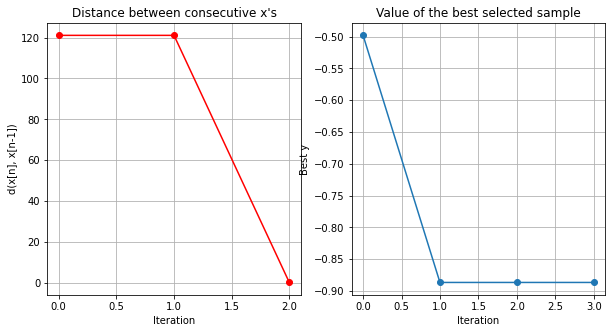

In [15]:
optimizer.plot_acquisition()
optimizer.plot_convergence()

In [17]:
optimizer.save_evaluations(evaluations_file='bayes_opt.txt')

print("="*100)
print("Max Val accuracy:  {0:.1%}".format(-optimizer.fx_opt[0])) 
print("Hyperparmeters' values that maximize the objective:"+str(optimizer.x_opt))    
    
print("="*100)
print()



for i in range(optimizer.Y.shape[0]):
  
  print("Acc: {0:.1%}".format(-optimizer.Y[i][0]),
        "[" 
        "{0:.2}".format(optimizer.X[i][0]),
        int(optimizer.X[i][1]),
        "{0:.2}".format(optimizer.X[i][2]),
        "{}".format(optimizer.X[i][3]),
        int(optimizer.X[i][4]),
        "]"
        
        )


Max Val accuracy:  88.6%
Hyperparmeters' values that maximize the objective:[ 32.    -4.   128.     0.75  -5.  ]

Acc: 49.8% [1.6e+01 -5 8.0 0.5 -8 ]
Acc: 88.6% [3.2e+01 -4 1.3e+02 0.75 -5 ]
Acc: 55.1% [1.6e+01 -5 8.0 0.5060793743796895 -8 ]
Acc: 63.0% [1.6e+01 -5 8.0 0.6575468187378135 -8 ]
